<h1>Segmentez les clients d'un site d'e-commerce - Partie 2: Modelisation</h1>

* [1. Préparation des données et modules](#10)
    * [1.1 Chargements des modules](#11)
    * [1.2 Chargement des données](#12)
    * [1.3 Conversion au format Datetime](#13)
* [2. Sélection des données pour la modélisation](#20)
* [3.Essais de Segmentation](#30)
    * [3.1 Segmentation avec K-Means](#31)
        * [3.1.1 Segmentation RFM](#311)
        * [3.1.2 Segmentation RFM + review score](#312)
        * [3.1.3 Segmentation avec 5 variables](#313)
        * [3.1.4 Segmentation avec 6 variables](#314)
    * [3.2 Segmentation avec Manuelle](#32)
    * [3.3 Segmentation avec DBSCAN](#33)
    * [3.4 Segmentation avec le clustering agglomératif](#34)


<h1>1. Préparation des données et modules</h1><a class="anchor" id="10"></a>
<h2>1.1 Chargements des modules</h2><a class="anchor" id="11"></a>

In [1]:
#pip install cutecharts #utilisé pour le radar chart expliquant les clusters
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

from itertools import product

from yellowbrick.cluster import SilhouetteVisualizer

<h2>1.2 Chargement des données</h2><a class="anchor" id="12"></a>

In [2]:
df = pd.read_csv('olist.csv')
df.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,estimated_time,total_time,delta_time,payment_type,payment_value,customer_unique_id,customer_city,customer_state,review_score,geolocation_lat,geolocation_lng
68391,7ee20272eb00cd391603903aad03de4c,1d31c85135ba6326c03dc4fd6e7c74cc,delivered,2017-08-24 19:33:26,2017-08-30 22:33:08,2017-09-06,12,6.0,-6.0,boleto,68.62,a0e250c2abfcb1e4e61e1ddf8e3b6379,indaiatuba,SP,5.0,-23.122053,-47.249701
16085,fad1f2027ab155751ea0746b70f81921,a22d55a6ebd23e2239a3bc5de97c7036,delivered,2018-08-04 18:43:08,2018-08-13 19:41:33,2018-08-16,11,9.0,-2.0,credit_card,70.97,6ae4955db9c67243996f71e3572d7678,sao paulo,SP,3.0,-23.608243,-46.694666
81466,87c10d50798c3cb5476f246e91921a0b,2356eca41ad970e57a898ab088d52b88,delivered,2017-09-02 20:27:18,2017-09-29 16:35:35,2017-09-28,25,26.0,1.0,credit_card,472.94,41789ad60c3f4ce775dcc1652a9c26b5,balneario camboriu,SC,4.0,-27.013903,-48.605554
66996,132d431a6757fe865a1f7117978bd0e0,b02ecf867fe6e02059318f0496ca67af,delivered,2018-04-02 15:10:14,2018-04-05 19:32:50,2018-04-12,9,3.0,-6.0,credit_card,213.29,cbda48699ce0eddc2bed9c71fab9757a,sao paulo,SP,5.0,-23.501420,-46.505062
27502,30f54cfb85a2cf596ee5b7a589d3ffa0,e8e7b23c38d42a5fc49b092371bef664,delivered,2017-11-22 10:17:50,2017-11-30 14:33:41,2017-12-08,15,8.0,-7.0,credit_card,130.14,026bae191fa488af0155ef3eba3d4a79,campinas,SP,2.0,-22.907668,-47.084814


<h2>1.3 Conversion au format datetime</h2><a class="anchor" id="13"></a>

In [3]:
datetime_cols = ['order_purchase_timestamp',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date']

In [4]:
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99440 entries, 0 to 99439
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99440 non-null  object        
 1   customer_id                    99440 non-null  object        
 2   order_status                   99440 non-null  object        
 3   order_purchase_timestamp       99440 non-null  datetime64[ns]
 4   order_delivered_customer_date  96475 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99440 non-null  datetime64[ns]
 6   estimated_time                 99440 non-null  int64         
 7   total_time                     96475 non-null  float64       
 8   delta_time                     96475 non-null  float64       
 9   payment_type                   99440 non-null  object        
 10  payment_value                  99440 non-null  float64       
 11  customer_unique

<h1>2. Sélection des données pour la modélisation</h1><a class="anchor" id="20"></a>

In [5]:
status_filter = (df['order_status'].isin(['delivered', 'shipped']))

df = df[status_filter].copy()

status_dic = {
    'delivered': 1,
    'shipped': 0
}

df['order_status'] = df['order_status'].map(status_dic)
df.shape

(97584, 17)

In [6]:
df['order_delivered_customer_date'].fillna(value=df['order_estimated_delivery_date'], inplace=True)

C:\Users\apetit\AppData\Local\Temp\ipykernel_140\2131845630.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['order_delivered_customer_date'].fillna(value=df['order_estimated_delivery_date'], inplace=True)


In [7]:
%%time

agg_dic = {'order_id': 'count',
          'order_status': 'min',
          'order_delivered_customer_date': 'max',
          'order_estimated_delivery_date': 'max',
           'payment_value': 'sum',
           'review_score': 'min'
          }

grouped = df.groupby('customer_unique_id').agg(agg_dic).reset_index()

CPU times: total: 125 ms
Wall time: 181 ms


In [8]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94398 entries, 0 to 94397
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             94398 non-null  object        
 1   order_id                       94398 non-null  int64         
 2   order_status                   94398 non-null  int64         
 3   order_delivered_customer_date  94398 non-null  datetime64[ns]
 4   order_estimated_delivery_date  94398 non-null  datetime64[ns]
 5   payment_value                  94398 non-null  float64       
 6   review_score                   93725 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 5.0+ MB


In [9]:
grouped['review_score'].fillna(5, inplace=True)
grouped['review_score'] = round(grouped['review_score'])

C:\Users\apetit\AppData\Local\Temp\ipykernel_140\2183548327.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  grouped['review_score'].fillna(5, inplace=True)


In [10]:
grouped['delta_delivery'] = (grouped['order_estimated_delivery_date'] - grouped['order_delivered_customer_date']).dt.days

In [11]:
grouped.columns

Index(['customer_unique_id', 'order_id', 'order_status',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_value', 'review_score', 'delta_delivery'],
      dtype='object')

In [12]:
grouped.columns = ['customer_unique_id', 'order_count', 'order_status',
       'last_order_delivery', 'estimated_delivery_date',
       'payment_value', 'review_score', 'delta_delivery']

In [13]:
grouped['todays_date'] = '2018-10-20'

grouped['todays_date'] = pd.to_datetime(grouped['todays_date'])

grouped['days_since_last_order'] = grouped['todays_date'] - grouped['last_order_delivery']

grouped['days_since_last_order'] = grouped['days_since_last_order'].dt.days

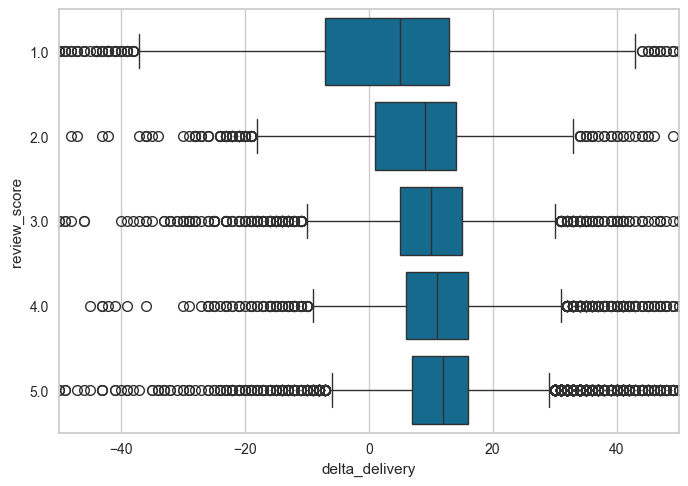

In [14]:
sns.boxplot(data=grouped, x='delta_delivery', y='review_score', orient='h')
plt.xlim([-50,50]);

La différence entre la date prévu de livraison et la date réelle à un impact sur le score. Toutefois il y a aussi beaucoup d'outliers.

Nous pouvons donc nous posez les questions suivantes
* pourquoi certaines commandes arrivent à des dates très éloignées de la date prévue?
* comment peut-on améliorer le système de suivies de colis (livraisons disparues ou perdus)?
* faire une meilleure distinction entre les problèmes liées au produit, au vendeur, au livreur, a olist

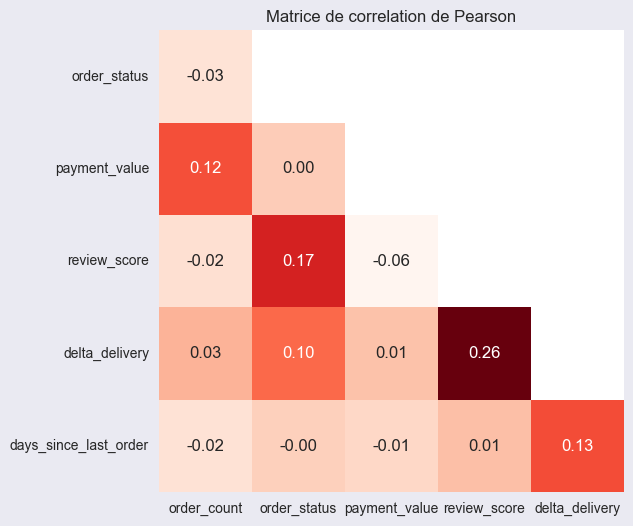

In [15]:
sample = grouped.sample(frac=0.1, random_state=42)

corr = sample.corr(numeric_only=True)

mask = np.triu(corr)

plt.figure(figsize=(6,6), facecolor='#eaeaf2')

sns.heatmap(corr.iloc[1:,:-1], annot=True, mask=mask[1:,:-1], cbar=None, cmap='Reds', fmt='.2f')
plt.grid(None)
plt.title('Matrice de correlation de Pearson');

In [16]:
grouped.to_csv('grouped.csv', index=False)

<h1>3. Essais de Segmentation</h1><a class="anchor" id="30"></a>

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from time import perf_counter
from datetime import datetime as dt

In [18]:
min_date = dt.strptime('2017-01-01', "%Y-%m-%d")
max_date = dt.strptime('2018-10-31', '%Y-%m-%d')

min_date_filter = (grouped['last_order_delivery'] > min_date)
max_date_filter = (grouped['last_order_delivery'] < max_date)

grouped = grouped[min_date_filter & max_date_filter]

sample = grouped.sample(frac=0.1, random_state=32)

<h2>3.1 Segmentation avec K-Means</h2><a class="anchor" id="31"></a>
<h2>3.1.1 Segmentation RFM</h2><a class="anchor" id="311"></a>

In [19]:
X = sample[['order_count', 'days_since_last_order', 'payment_value']].copy()

scaler = StandardScaler().set_output(transform='pandas')

X_scaled = scaler.fit_transform(X)

In [20]:
def k_elbow_scorer(data, n_cluster_grid):
    
    model_score = pd.DataFrame(columns=['n_clusters', 'silhouette_score', 'calinski-harabasz', 'time'])
    
    for n in cluster_grid:
        
        start_time = perf_counter()
        
        model = KMeans(n_clusters=n, n_init='auto')
        
        print(f"Fitting model with {n} clusters...\n")
        model.fit(data)
        
        end_time = perf_counter()
        
        elapsed_time = round(end_time - start_time)
        
        clusters = model.labels_
        
        calinski = calinski_harabasz_score(data, clusters)
        
        silhouette = silhouette_score(data, clusters)
        
        results = {'n_clusters': n,
                  'silhouette_score': silhouette,
                  'calinski-harabasz': calinski,
                  'time': elapsed_time}
        
        l = len(model_score)
        
        model_score.loc[l] = results
        
    return model_score

In [21]:
cluster_grid = [3,4,5,6,7]

score_RFM = k_elbow_scorer(X_scaled, cluster_grid)
score_RFM

Fitting model with 3 clusters...

Fitting model with 4 clusters...

Fitting model with 5 clusters...

Fitting model with 6 clusters...

Fitting model with 7 clusters...



,n_clusters,silhouette_score,calinski-harabasz,time
0,3,0.449416,3631.365177,0
1,4,0.482028,4850.616623,0
2,5,0.407102,4550.242433,0
3,6,0.429079,4650.026592,0
4,7,0.495835,5904.966912,0


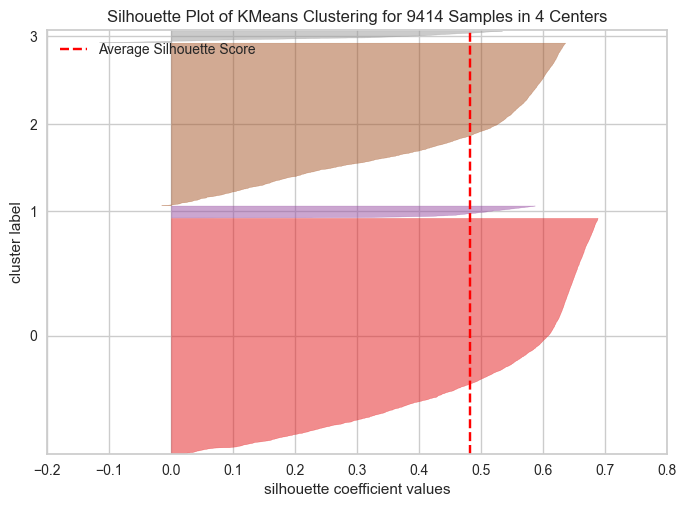

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 9414 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
model = KMeans(n_clusters=4, n_init='auto')

viz = SilhouetteVisualizer(model, color='yellowbrick')
viz.fit(X_scaled)
model.fit(X_scaled)

X['clusters'] = model.labels_

viz.show()

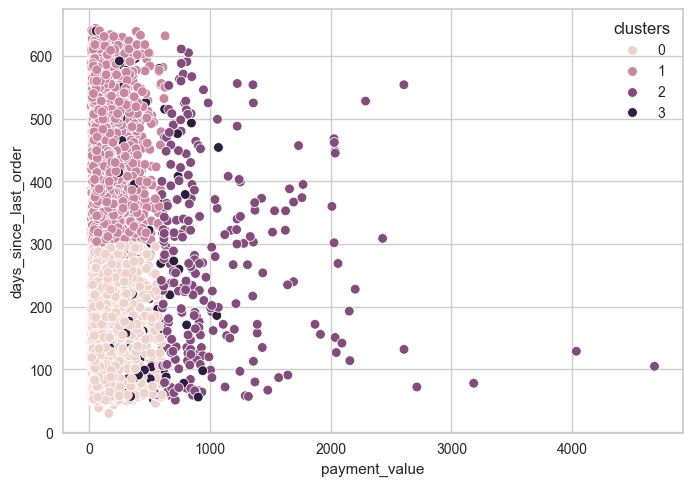

In [23]:
sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

In [24]:
results = X.groupby('clusters')[['payment_value', 'days_since_last_order', 'order_count']].mean().reset_index()
results.set_index('clusters', inplace=True)
results

,payment_value,days_since_last_order,order_count
clusters,,,
0,131.554867,170.406274,1.000000
1,128.796471,427.243251,1.000000
2,1037.540778,272.470817,1.003891
3,278.178839,258.367041,2.157303


In [25]:
scaled_results = results.copy()

scaled_results['days_since_last_order'] = round(scaled_results['days_since_last_order'] /  scaled_results['days_since_last_order'].max(), 2)
scaled_results['order_count'] = round(scaled_results['order_count'] /  scaled_results['order_count'].max(), 2)
scaled_results['payment_value'] = round(scaled_results['payment_value'] /  scaled_results['payment_value'].max(), 2)

import cutecharts.charts as ctc

chart = ctc.Radar('Mean Values for Each Clusters')

chart.set_options(
    labels=list(results.columns)
)

for row in scaled_results.itertuples(name=None):
    chart.add_series(f'cluster {row[0]}', list(row[1:]))
    
chart.render_notebook()

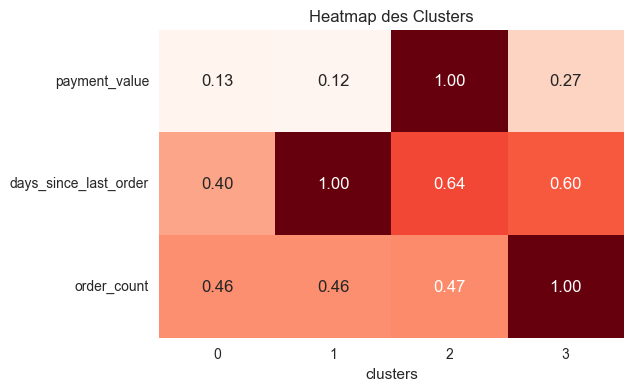

In [26]:
plt.figure(figsize=(6,4))
sns.heatmap(scaled_results.T, annot=True, fmt='.2f', cbar=None, cmap='Reds')
plt.title('Heatmap des Clusters');

Nous pouvons noter la présence d'un cluster pour les sommes plus élevées, un pour les clients à commandes multiples, et deux clusters basés sur la période d'achat

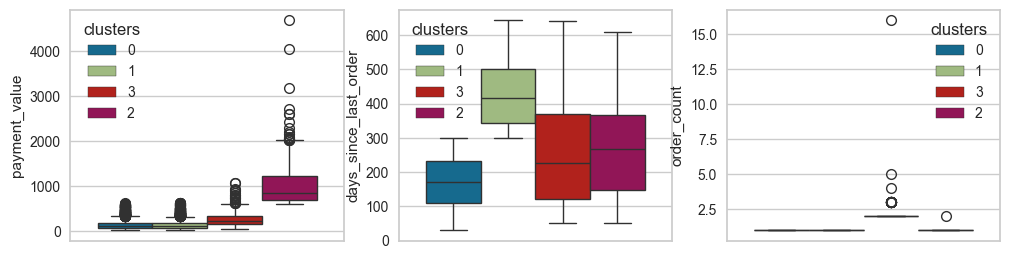

In [27]:
X['clusters'] = X['clusters'].astype(str)
fig, ax = plt.subplots(1,3, figsize=(12,3))

sns.boxplot(data=X, y='payment_value', hue='clusters', ax=ax[0])
sns.boxplot(data=X, y='days_since_last_order', hue='clusters', ax=ax[1])
sns.boxplot(data=X, y='order_count', hue='clusters', ax=ax[2]);

<h2>3.1.2 Segmentation RFM + review score</h2><a class="anchor" id="312"></a>

In [28]:
X = sample[['order_count', 'days_since_last_order', 'payment_value', 'review_score']].copy()
X_scaled = scaler.fit_transform(X)

scoreRFMS = k_elbow_scorer(X_scaled, cluster_grid)
scoreRFMS

Fitting model with 3 clusters...

Fitting model with 4 clusters...

Fitting model with 5 clusters...

Fitting model with 6 clusters...

Fitting model with 7 clusters...



,n_clusters,silhouette_score,calinski-harabasz,time
0,3,0.350951,2549.115187,0
1,4,0.329472,2648.927605,0
2,5,0.406797,3808.551686,0
3,6,0.331922,3524.404059,0
4,7,0.379240,4094.949071,0


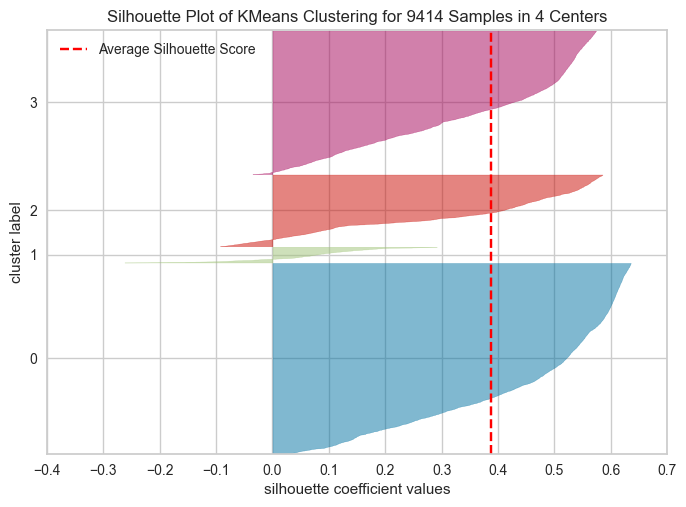

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 9414 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
model = KMeans(n_clusters=4, n_init='auto')

viz = SilhouetteVisualizer(model, colors='yellowbrick')
viz.fit(X_scaled)

model.fit(X_scaled)

X['clusters'] = model.labels_

viz.show()

In [30]:
results = X.groupby('clusters')[['payment_value', 'order_count', 'days_since_last_order', 'review_score']].median().reset_index()
results.set_index('clusters', inplace=True)
results

,payment_value,order_count,days_since_last_order,review_score
clusters,,,,
0,98.145,1.0,420.0,5.0
1,115.910,1.0,238.0,1.0
2,296.560,2.0,242.0,5.0
3,104.855,1.0,163.0,5.0


In [31]:
scaled_results = results.copy()

for col in scaled_results.columns:
    scaled_results[col] = round(scaled_results[col] / scaled_results[col].max(), 2)
    
chart = ctc.Radar('Mean Values for Each Clusters')

chart.set_options(
    labels=list(results.columns)
)

for row in scaled_results.itertuples(name=None):
    chart.add_series(f'cluster {row[0]}', row[1:])
    
chart.render_notebook()

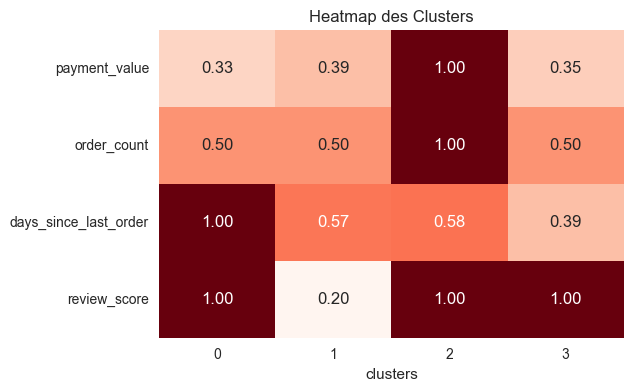

In [32]:
plt.figure(figsize=(6,4))
sns.heatmap(scaled_results.T, annot=True, fmt='.2f', cbar=None, cmap='Reds')
plt.title('Heatmap des Clusters');

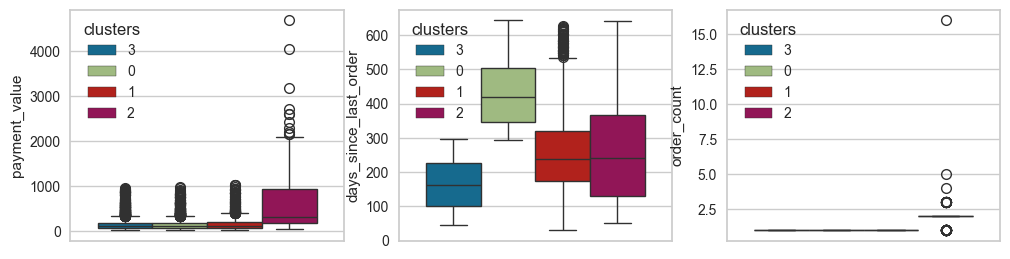

In [33]:
X['clusters'] = X['clusters'].astype(str)
fig, ax = plt.subplots(1,3, figsize=(12,3))

sns.boxplot(data=X, y='payment_value', hue='clusters', ax=ax[0])
sns.boxplot(data=X, y='days_since_last_order', hue='clusters', ax=ax[1])
sns.boxplot(data=X, y='order_count', hue='clusters', ax=ax[2]);

<h2>3.1.3 Segmentation avec 5 colonnes</h2><a class="anchor" id="313"></a>

In [34]:
cols = ['payment_value', 'order_count',
        'days_since_last_order', 'review_score',
        'delta_delivery']

X = sample[cols].copy()
X_scaled = scaler.fit_transform(X)

score_RFMSD = k_elbow_scorer(X_scaled, cluster_grid)
score_RFMSD

Fitting model with 3 clusters...

Fitting model with 4 clusters...

Fitting model with 5 clusters...

Fitting model with 6 clusters...

Fitting model with 7 clusters...



,n_clusters,silhouette_score,calinski-harabasz,time
0,3,0.265731,2033.642821,0
1,4,0.266866,1923.519434,0
2,5,0.306601,2484.724260,0
3,6,0.193555,1960.430149,0
4,7,0.313212,2464.120032,0


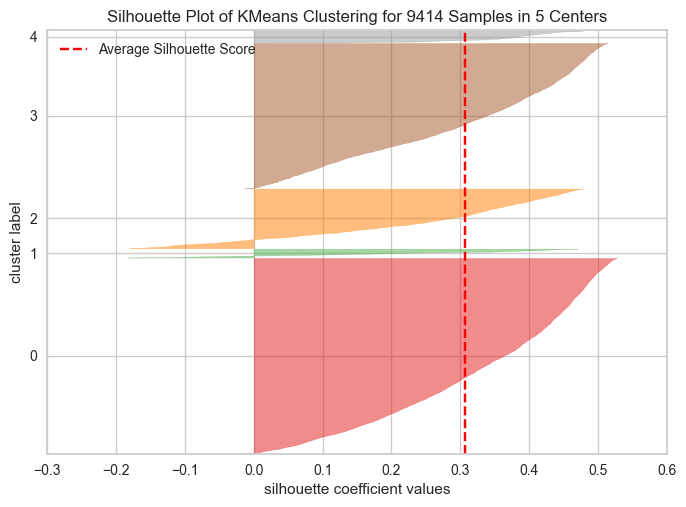

,payment_value,order_count,days_since_last_order,review_score,delta_delivery
clusters,,,,,
0,128.702064,1.000000,427.632678,4.598894,12.908784
1,1152.246300,1.005000,273.945000,3.815000,10.055000
2,149.382622,1.000000,260.032307,1.535687,1.934636
3,132.528972,1.000000,166.052982,4.636239,11.868349
4,278.178839,2.157303,258.367041,3.985019,12.089888


In [35]:
model = KMeans(n_clusters=5, n_init='auto')

viz = SilhouetteVisualizer(model, color='yellowbricks')
viz.fit(X_scaled)
viz.show()

model.fit(X_scaled)

X['clusters'] = model.labels_

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
display(results)

In [36]:
scaled_results = results.copy()

for col in scaled_results.columns:
    scaled_results[col] = round(scaled_results[col] / scaled_results[col].max(), 2)
    
chart = ctc.Radar('Mean Values for Each Clusters')

chart.set_options(
    labels=list(results.columns)
)

for row in scaled_results.itertuples(name=None):
    chart.add_series(f'cluster {row[0]}', row[1:])
    
chart.render_notebook()

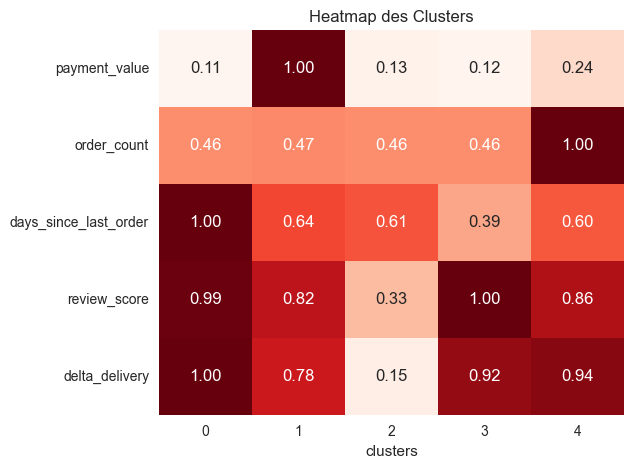

In [37]:
plt.figure(figsize=(6,5))
sns.heatmap(scaled_results.T, annot=True, fmt='.2f', cbar=None, cmap='Reds')
plt.title('Heatmap des Clusters');

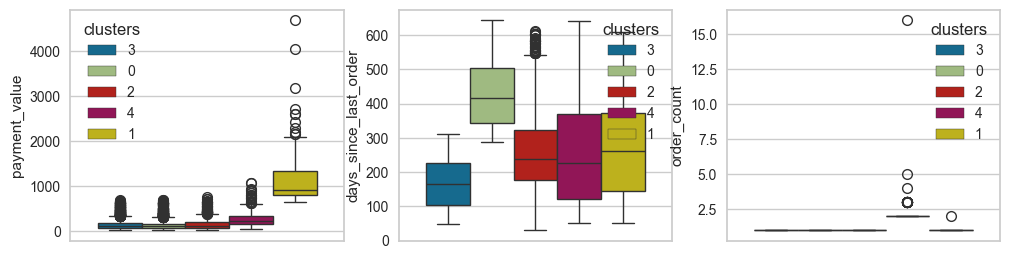

In [38]:
X['clusters'] = X['clusters'].astype(str)
fig, ax = plt.subplots(1,3, figsize=(12,3))

sns.boxplot(data=X, y='payment_value', hue='clusters', ax=ax[0])
sns.boxplot(data=X, y='days_since_last_order', hue='clusters', ax=ax[1])
sns.boxplot(data=X, y='order_count', hue='clusters', ax=ax[2]);

<h2>3.1.4 Segmentation avec 6 colonnes</h2><a class="anchor" id="314"></a>

In [39]:
cols = ['payment_value', 'order_count',
        'days_since_last_order', 'review_score',
        'delta_delivery', 'order_status']
X = sample[cols].copy()
X_scaled = scaler.fit_transform(X)

score_RFMSDD = k_elbow_scorer(X_scaled, cluster_grid)
score_RFMSDD

Fitting model with 3 clusters...

Fitting model with 4 clusters...

Fitting model with 5 clusters...

Fitting model with 6 clusters...

Fitting model with 7 clusters...



,n_clusters,silhouette_score,calinski-harabasz,time
0,3,0.244005,1646.919665,0
1,4,0.267727,1726.477853,0
2,5,0.288488,2340.075417,0
3,6,0.310619,2693.344630,0
4,7,0.313718,2478.635496,0


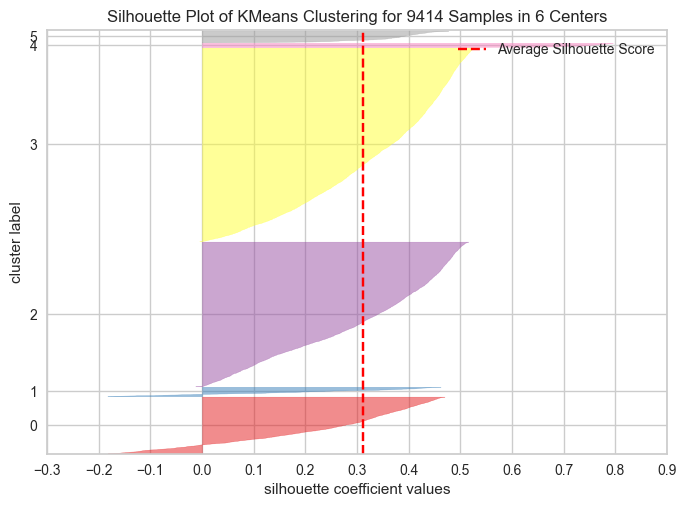

,payment_value,order_count,days_since_last_order,review_score,delta_delivery,order_status
clusters,,,,,,
0,120.980,1.0,242.0,1.0,4.0,1.0
1,88.490,1.0,183.0,5.0,7.0,1.0
2,132.875,1.0,256.5,1.0,0.0,0.0
3,98.220,1.0,437.0,5.0,13.0,1.0
4,289.430,2.0,245.5,5.0,13.0,1.0
5,132.925,1.0,169.0,5.0,18.0,1.0


In [40]:
model = KMeans(n_clusters=6, n_init='auto')

viz = SilhouetteVisualizer(model, color='yellowbrick')
viz.fit(X_scaled)
viz.show()

model.fit(X_scaled)

X['clusters'] = model.labels_

results = X.groupby('clusters')[cols].median().reset_index()
results.set_index('clusters', inplace=True)
display(results)

In [41]:
scaled_results = results.copy()

for col in scaled_results.columns:
    scaled_results[col] = round(scaled_results[col] / scaled_results[col].max(), 2)
    
chart = ctc.Radar('Mean Values for Each Clusters')

chart.set_options(
    labels=list(results.columns)
)

for row in scaled_results.itertuples(name=None):
    chart.add_series(f'cluster {row[0]}', row[1:])
    
chart.render_notebook()

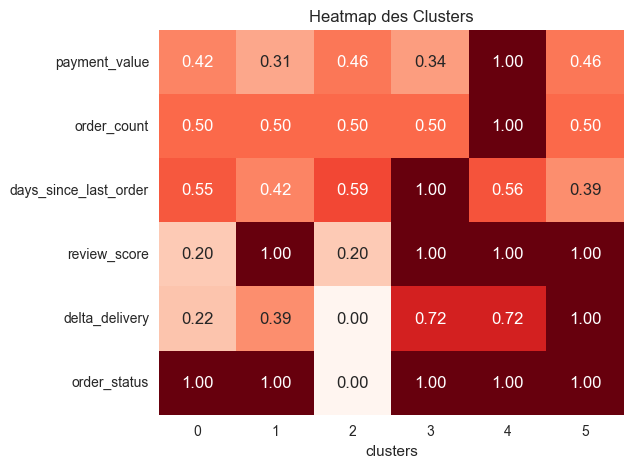

In [42]:
plt.figure(figsize=(6,5))
sns.heatmap(scaled_results.T, annot=True, fmt='.2f', cbar=None, cmap='Reds')
plt.title('Heatmap des Clusters');

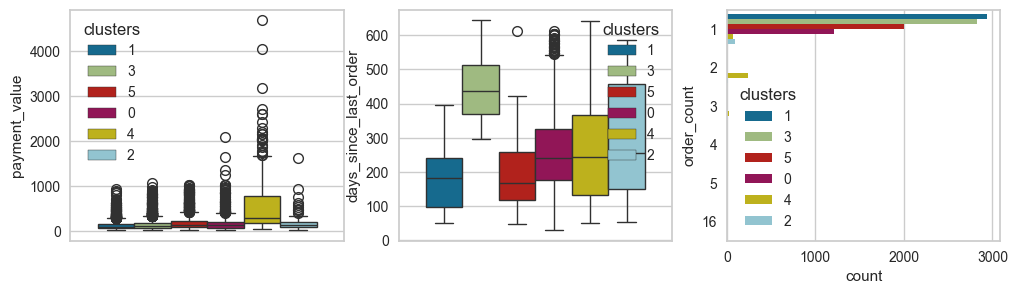

In [43]:
X['clusters'] = X['clusters'].astype(str)
fig, ax = plt.subplots(1,3, figsize=(12,3))

sns.boxplot(data=X, y='payment_value', hue='clusters', ax=ax[0])
sns.boxplot(data=X, y='days_since_last_order', hue='clusters', ax=ax[1])
sns.countplot(data=X, y='order_count', hue='clusters', ax=ax[2]);

le cluster 3 est celui avec les commandes dont la livraisons n'a pas été éffectuée, le score est aussi le plus faible

<h2>3.1.5 Segmentation RSM (Récence, Satisfaction, Montant)</h2>

In [44]:
cols = [
    'payment_value',
    'days_since_last_order',
    'review_score'
]

X = sample[cols].copy()
X['review_score'] = [0 if score < 4 else 1 for score in X.review_score]

X.review_score.value_counts()

review_score
1    7415
0    1999
Name: count, dtype: int64

In [45]:
X_scaled = scaler.fit_transform(X)

score_RSM = k_elbow_scorer(X_scaled, cluster_grid)
score_RSM

Fitting model with 3 clusters...

Fitting model with 4 clusters...

Fitting model with 5 clusters...

Fitting model with 6 clusters...

Fitting model with 7 clusters...



,n_clusters,silhouette_score,calinski-harabasz,time
0,3,0.449849,5174.732119,0
1,4,0.479606,6997.631951,0
2,5,0.490175,6701.314479,0
3,6,0.491915,6921.935306,0
4,7,0.440044,7529.064939,0


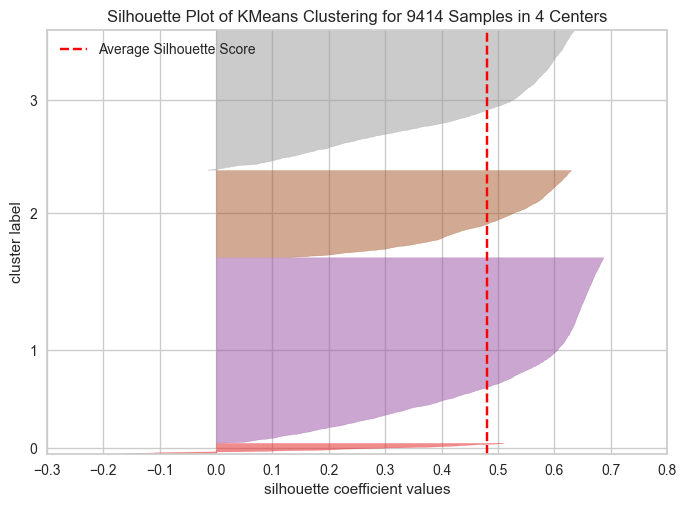

,payment_value,days_since_last_order,review_score
clusters,,,
0,106.93,163.0,1.0
1,99.16,408.0,1.0
2,880.23,265.5,1.0
3,112.25,245.0,0.0


In [46]:
model = KMeans(n_clusters=4, n_init='auto')

viz = SilhouetteVisualizer(model, color='yellowbrick')
viz.fit(X_scaled)
viz.show()

model.fit(X_scaled)

X['clusters'] = model.labels_

results = X.groupby('clusters')[cols].median().reset_index()
results.set_index('clusters', inplace=True)
display(results)

In [ ]:
X['clusters'].value_counts()

In [47]:
scaled_results = results.copy()

for col in scaled_results.columns:
    scaled_results[col] = round(scaled_results[col] / scaled_results[col].max(), 2)
    
chart = ctc.Radar('Mean Values for Each Clusters')

chart.set_options(
    labels=list(results.columns)
)

for row in scaled_results.itertuples(name=None):
    chart.add_series(f'cluster {row[0]}', row[1:])
    
chart.render_notebook()

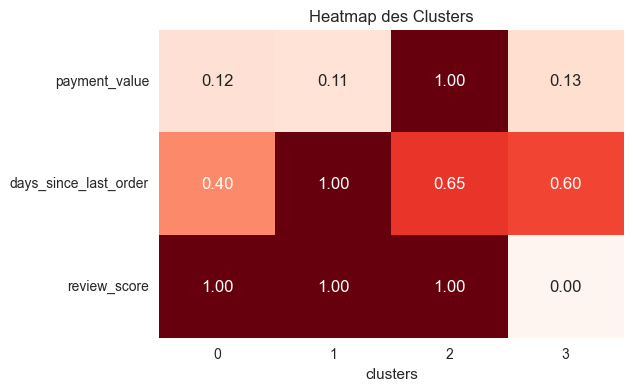

In [48]:
plt.figure(figsize=(6,4))
sns.heatmap(scaled_results.T, annot=True, fmt='.2f', cbar=None, cmap='Reds')
plt.title('Heatmap des Clusters');

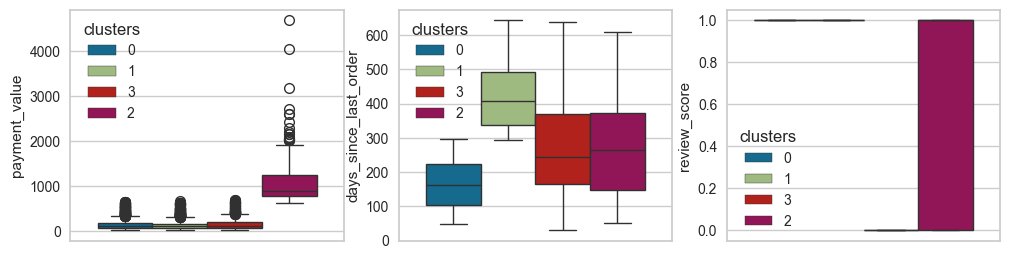

In [49]:
X['clusters'] = X['clusters'].astype(str)
fig, ax = plt.subplots(1,3, figsize=(12,3))

sns.boxplot(data=X, y='payment_value', hue='clusters', ax=ax[0])
sns.boxplot(data=X, y='days_since_last_order', hue='clusters', ax=ax[1])
sns.boxplot(data=X, y='review_score', hue='clusters', ax=ax[2]);

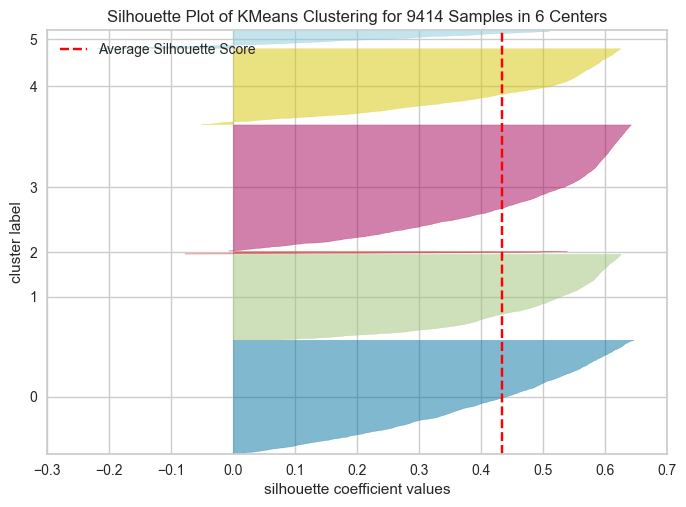

,payment_value,days_since_last_order,review_score
clusters,,,
0,616.410,238.0,1.0
1,111.020,245.0,0.0
2,97.835,490.0,1.0
3,1596.330,300.5,1.0
4,105.990,130.0,1.0
5,98.010,304.0,1.0


In [50]:
model = KMeans(n_clusters=6, n_init='auto')

viz = SilhouetteVisualizer(model, colors='yellowbrick')
viz.fit(X_scaled)
viz.show()

model.fit(X_scaled)

X['clusters'] = model.labels_

results = X.groupby('clusters')[cols].median().reset_index()
results.set_index('clusters', inplace=True)
results

In [51]:
scaled_results = results.copy()

for col in scaled_results.columns:
    scaled_results[col] = round(scaled_results[col] / scaled_results[col].max(), 2)
    
chart = ctc.Radar('Median Values for Each Clusters')

chart.set_options(
    labels=list(results.columns)
)

for row in scaled_results.itertuples(name=None):
    chart.add_series(f'cluster {row[0]}', row[1:])
    
chart.render_notebook()

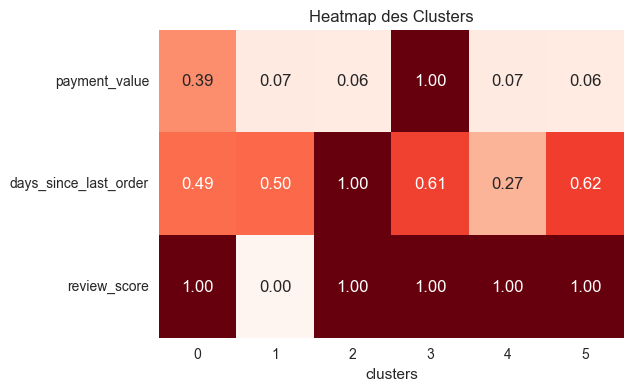

In [52]:
plt.figure(figsize=(6,4))
sns.heatmap(scaled_results.T, annot=True, fmt='.2f', cbar=None, cmap='Reds')
plt.title('Heatmap des Clusters');

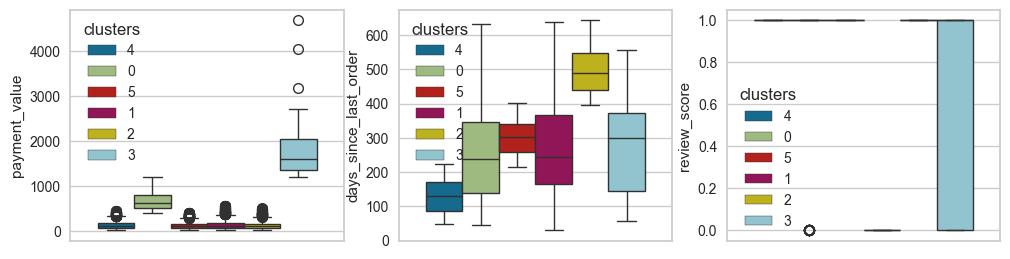

In [53]:
X['clusters'] = X['clusters'].astype(str)
fig, ax = plt.subplots(1,3, figsize=(12,3))

sns.boxplot(data=X, y='payment_value', hue='clusters', ax=ax[0])
sns.boxplot(data=X, y='days_since_last_order', hue='clusters', ax=ax[1])
sns.boxplot(data=X, y='review_score', hue='clusters', ax=ax[2]);

En utilisant 6 clusters, la valeur moyenne de "days_since_last_order" semble être très variable entre les clusters. Si cette variable prend trop d'importance, les clusters ne résisteront pas au temps.

<h2>3.2 Segmentation Manuelle</h2><a class="anchor" id="32"></a>

Pour segmenter les données manuellement, nous devons décider de valeurs seuils.
* Le premier seuil est celui des clients ayant données une note inférieur à 4, nous l'avons déjà encodé
* Le second seuil pourrait être les 25% de clients ayant dépensés le plus
* Enfin nous allon séparé les derniers clients entre les clients récents et les clients de plus de six mois

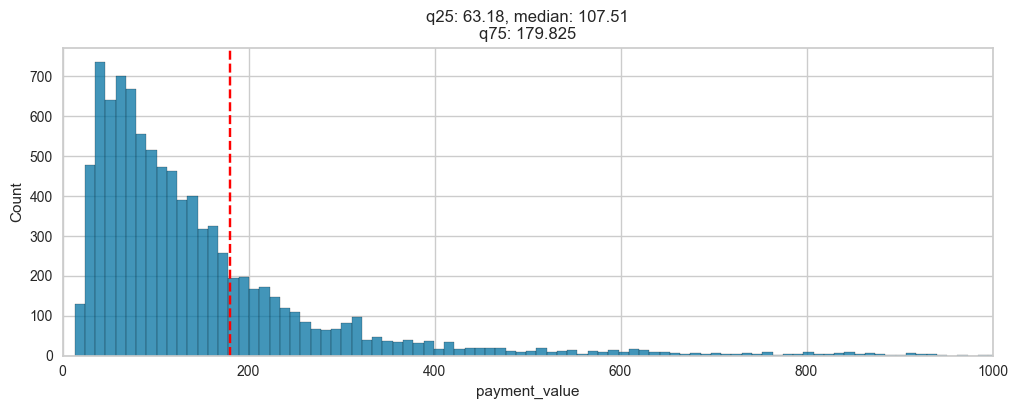

In [54]:
q_25 = np.quantile(sample['payment_value'], 0.25)
q_50 = np.median(sample['payment_value'])
q_75 = np.quantile(sample['payment_value'], 0.75)


title = f"q25: {q_25}, median: {q_50:.2f}\n"
title += f"q75: {q_75}"

plt.figure(figsize=(12,4))
sns.histplot(data=sample, x='payment_value')
plt.xlim([0,1000])
plt.axvline(x=q_75, linestyle="--", color='red')
plt.title(title);

In [55]:
sample.columns

Index(['customer_unique_id', 'order_count', 'order_status',
       'last_order_delivery', 'estimated_delivery_date', 'payment_value',
       'review_score', 'delta_delivery', 'todays_date',
       'days_since_last_order'],
      dtype='object')

In [56]:
X = sample[['days_since_last_order', 'payment_value', 'review_score']].copy()

X['review_score'] = [0 if score < 4 else 1 for score in sample['review_score']]

X['cluster'] = 0

#first_filter = df['review_score']

In [57]:
X.review_score.value_counts()

review_score
1    7415
0    1999
Name: count, dtype: int64

In [58]:
first_filter = (X['review_score'] == 0)
second_filter = (X['payment_value'] > 180)
third_filter = (X['days_since_last_order'] < 180)

first_cluster = X[first_filter].copy()
remainder = X[~first_filter].copy()

second_cluster = remainder[second_filter].copy()
remainder = remainder[~second_filter].copy()

third_cluster = remainder[third_filter].copy()
fourth_cluster = remainder[~third_filter].copy()

print(first_cluster.shape[0])
print(second_cluster.shape[0])
print(third_cluster.shape[0])
print(fourth_cluster.shape[0])

1999
1770
1820
3825


C:\Users\apetit\AppData\Local\Temp\ipykernel_140\732982390.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  second_cluster = remainder[second_filter].copy()
C:\Users\apetit\AppData\Local\Temp\ipykernel_140\732982390.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  remainder = remainder[~second_filter].copy()
C:\Users\apetit\AppData\Local\Temp\ipykernel_140\732982390.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  third_cluster = remainder[third_filter].copy()
C:\Users\apetit\AppData\Local\Temp\ipykernel_140\732982390.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fourth_cluster = remainder[~third_filter].copy()


In [59]:
first_cluster['cluster'] = 1
second_cluster['cluster'] = 2
third_cluster['cluster'] = 3
fourth_cluster['cluster'] = 4

clustered = pd.concat([first_cluster, second_cluster, third_cluster, fourth_cluster], axis=0)
clustered.head()

,days_since_last_order,payment_value,review_score,cluster
83577,311,159.31,0,1
66655,189,165.24,0,1
65808,583,196.75,0,1
88705,393,75.66,0,1
86797,30,162.25,0,1


In [60]:
clustered = clustered.sort_index()
clustered.head()

,days_since_last_order,payment_value,review_score,cluster
2,562,86.22,0,1
14,423,91.28,1,4
15,371,46.85,1,4
35,420,91.21,1,4
41,473,36.73,1,4


In [61]:
print(round(silhouette_score(clustered.drop('cluster', axis=1), clustered['cluster']), 2))

0.11


Le silhouette score est bien plus faible que ce que nous avons obtenus avec le kmeans.

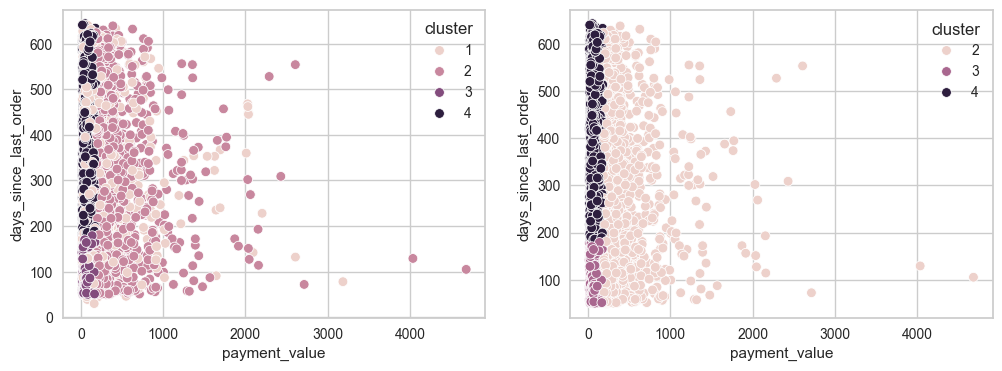

In [62]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(data=clustered,
                x='payment_value',
                y='days_since_last_order',
                hue='cluster',
                ax=ax[0])

sns.scatterplot(data=clustered[clustered['cluster'] != 1],
                x='payment_value',
                y='days_since_last_order',
                hue='cluster',
               ax=ax[1]);

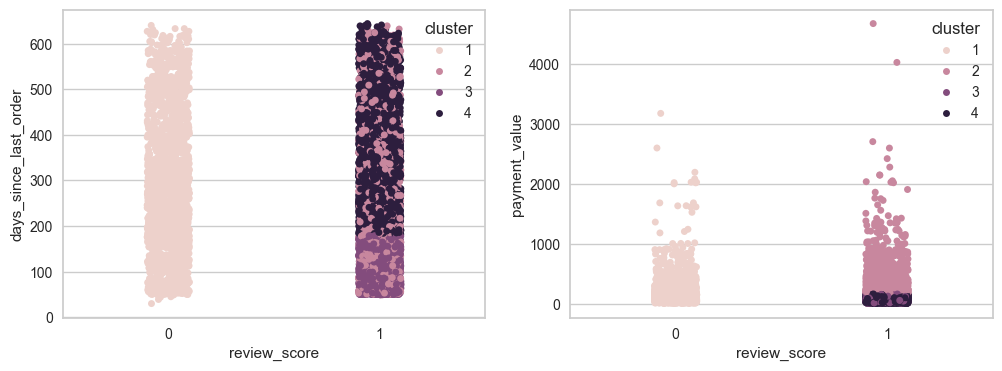

In [63]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.stripplot(data=clustered, x='review_score', y='days_since_last_order', hue='cluster', ax=ax[0])
sns.stripplot(data=clustered, x='review_score', y='payment_value', hue='cluster', ax=ax[1]);

Même si notre méthode de clusterisation manuelle ne nous donne pas le score silhouette le plus élevé, nous pouvons voir des clusters très distincts.
Les clusters que nous avons crées permettent de voir:
* Les clients non-satisfaits
* Les clients à fort budgets
* Les clients à petit budget ayant commandés dans les six mois

<h2>3.3 Segmentation avec DBSCAN</h2><a class="anchor" id="33"></a>

In [64]:
def db_scan_scorer(data, epsilon_grid):
    
    score_df = pd.DataFrame(columns=['epsilon', 'n_clusters',
                                     'silhouette', 'calinski-harabasz',
                                     'time'])
    
    for e in epsilon_grid:
        
        start_time = perf_counter()
        
        model = DBSCAN(eps=e)
        
        model.fit(X_scaled)
        
        end_time = perf_counter()
        
        elapsed = round(end_time - start_time, 3)
        
        clusters = model.labels_
        
        silhouette = round(silhouette_score(X_scaled, clusters), 2)
        
        calinski = round(calinski_harabasz_score(X_scaled, clusters), 2)
        
        
        n_clusters = len(set(clusters))
        
        row = {'epsilon': e,
               'n_clusters': n_clusters,
              'silhouette': silhouette,
              'calinski-harabasz': calinski,
              'time': elapsed}
        
        l = len(score_df)
        
        score_df.loc[l] = row
        
    return score_df

In [65]:
X = sample[['order_count', 'days_since_last_order', 'payment_value']].copy()
X_scaled = scaler.fit_transform(X)

epsilons = np.arange(0.1, 1.1, 0.1)

dbscan_RFM = db_scan_scorer(X_scaled, epsilons)
dbscan_RFM

,epsilon,n_clusters,silhouette,calinski-harabasz,time
0,0.1,27,-0.03,111.63,0.285
1,0.2,15,0.46,285.54,0.303
2,0.3,6,0.58,778.90,0.449
3,0.4,5,0.65,1021.32,0.541
4,0.5,6,0.66,761.18,0.593
5,0.6,6,0.66,742.96,0.706
6,0.7,6,0.66,771.36,0.739
7,0.8,5,0.66,974.73,0.982
8,0.9,5,0.66,988.62,1.092
9,1.0,4,0.66,1040.06,1.143


In [66]:
model = DBSCAN(eps=0.9)

model.fit(X_scaled)

X['clusters'] = model.labels_

cols = ['payment_value', 'order_count', 'days_since_last_order']

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
results

,payment_value,order_count,days_since_last_order
clusters,,,
-1,1441.512083,2.833333,278.041667
0,150.136798,1.000000,275.250027
1,258.007479,2.000000,261.949580
2,2046.664667,1.000000,269.133333
3,287.962143,3.000000,148.500000


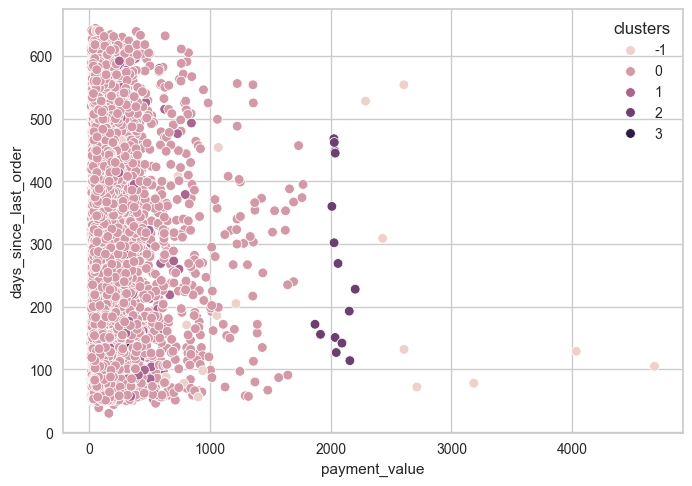

In [67]:
sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

In [68]:
model = DBSCAN(eps=0.4)

model.fit(X_scaled)

X['clusters'] = model.labels_

cols = ['payment_value', 'order_count', 'days_since_last_order']

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
results

,payment_value,order_count,days_since_last_order
clusters,,,
-1,1288.099800,1.77,285.960000
0,142.989503,1.00,275.119528
1,234.370852,2.00,253.206278
2,176.390000,3.00,122.600000
3,1276.652353,1.00,323.882353


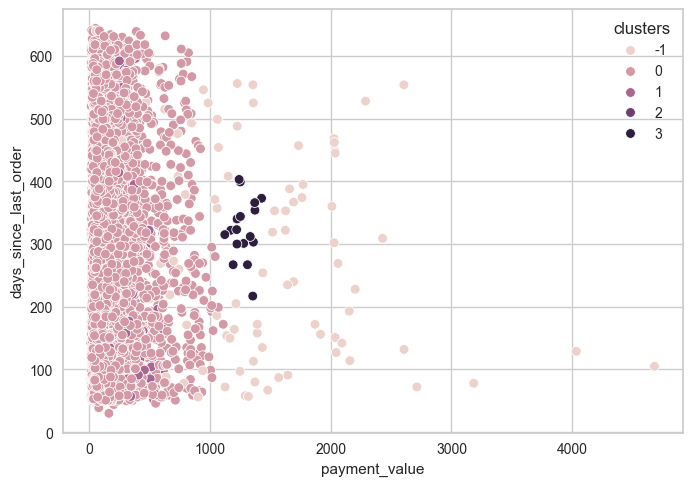

In [69]:
sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

In [70]:
def dbscan_scorer(data, epsilon_grid, sample_size):
    
    score_df = pd.DataFrame(columns=['epsilon', 'n_clusters', 'sample_size',
                                     'silhouette', 'calinski-harabasz',
                                     'time'])
    
    
    for e, n in product(epsilon_grid, sample_size):
        
        print(f'Fitting DBSCAN for epsilon: {e}, sample_size: {n}')
        
        start_time = perf_counter()
        
        model = DBSCAN(eps=e, min_samples=n)
        
        model.fit(X_scaled)
        
        end_time = perf_counter()
        
        elapsed = round(end_time - start_time, 3)
        
        clusters = model.labels_
        
        silhouette = round(silhouette_score(X_scaled, clusters), 2)
        
        calinski = round(calinski_harabasz_score(X_scaled, clusters), 2)
        
        n_clusters = len(set(clusters))
        
        row = {
            'epsilon': e,
            'sample_size': n,
            'n_clusters': n_clusters,
            'silhouette': silhouette,
            'calinski-harabasz': calinski,
            'time': elapsed
            
        }
        
        l = len(score_df)
        
        score_df.loc[l] = row
        
    
    return score_df

sample_size= [50, 100, 150]

score_dbscan = dbscan_scorer(sample, epsilons, sample_size)
score_dbscan

Fitting DBSCAN for epsilon: 0.1, sample_size: 50
Fitting DBSCAN for epsilon: 0.1, sample_size: 100
Fitting DBSCAN for epsilon: 0.1, sample_size: 150
Fitting DBSCAN for epsilon: 0.2, sample_size: 50
Fitting DBSCAN for epsilon: 0.2, sample_size: 100
Fitting DBSCAN for epsilon: 0.2, sample_size: 150
Fitting DBSCAN for epsilon: 0.30000000000000004, sample_size: 50
Fitting DBSCAN for epsilon: 0.30000000000000004, sample_size: 100
Fitting DBSCAN for epsilon: 0.30000000000000004, sample_size: 150
Fitting DBSCAN for epsilon: 0.4, sample_size: 50
Fitting DBSCAN for epsilon: 0.4, sample_size: 100
Fitting DBSCAN for epsilon: 0.4, sample_size: 150
Fitting DBSCAN for epsilon: 0.5, sample_size: 50
Fitting DBSCAN for epsilon: 0.5, sample_size: 100
Fitting DBSCAN for epsilon: 0.5, sample_size: 150
Fitting DBSCAN for epsilon: 0.6, sample_size: 50
Fitting DBSCAN for epsilon: 0.6, sample_size: 100
Fitting DBSCAN for epsilon: 0.6, sample_size: 150
Fitting DBSCAN for epsilon: 0.7000000000000001, sample_siz

,epsilon,n_clusters,sample_size,silhouette,calinski-harabasz,time
0,0.1,3,50,0.20,903.26,0.218
1,0.1,3,100,-0.12,689.10,0.223
2,0.1,4,150,-0.28,219.02,0.216
3,0.2,2,50,0.56,2180.58,0.323
4,0.2,2,100,0.47,1858.38,0.322
5,0.2,2,150,0.41,1668.50,0.376
6,0.3,2,50,0.63,2449.50,0.506
7,0.3,2,100,0.59,2276.33,0.491
8,0.3,2,150,0.55,2139.51,0.471
9,0.4,2,50,0.67,2565.48,0.561


,payment_value,order_count,days_since_last_order
clusters,,,
-1,636.707980,1.517529,277.232053
0,126.947639,1.000000,274.552127


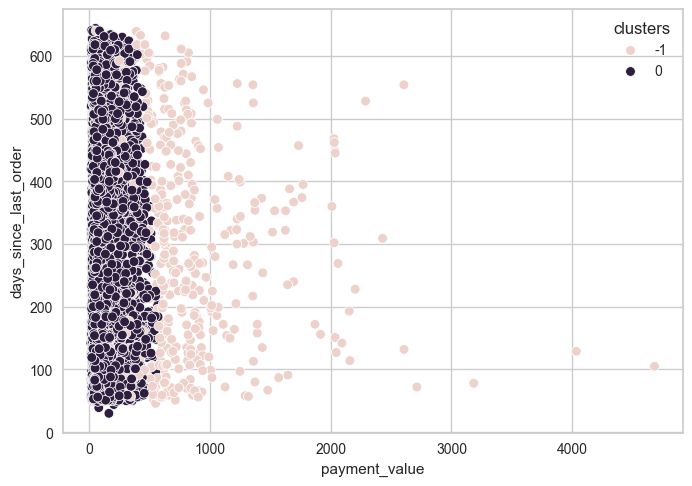

In [71]:
model = DBSCAN(eps=0.4, min_samples=50)

model.fit(X_scaled)

X['clusters'] = model.labels_

cols = ['payment_value', 'order_count', 'days_since_last_order']

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
display(results)

sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

,payment_value,order_count,days_since_last_order
clusters,,,
-1,804.341953,1.556851,316.638484
0,134.052707,1.000000,274.623995
1,205.902521,2.000000,161.327731


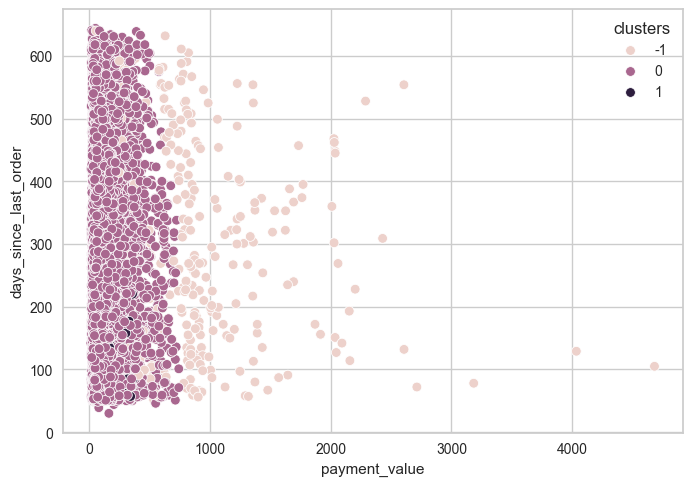

In [72]:
model = DBSCAN(eps=0.6, min_samples=50)

model.fit(X_scaled)

X['clusters'] = model.labels_

cols = ['payment_value', 'order_count', 'days_since_last_order']

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
display(results)

sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

,payment_value,order_count,days_since_last_order
clusters,,,
-1,1203.092923,1.715385,284.938462
0,142.836759,1.000000,275.050954
1,225.477189,2.000000,254.884793


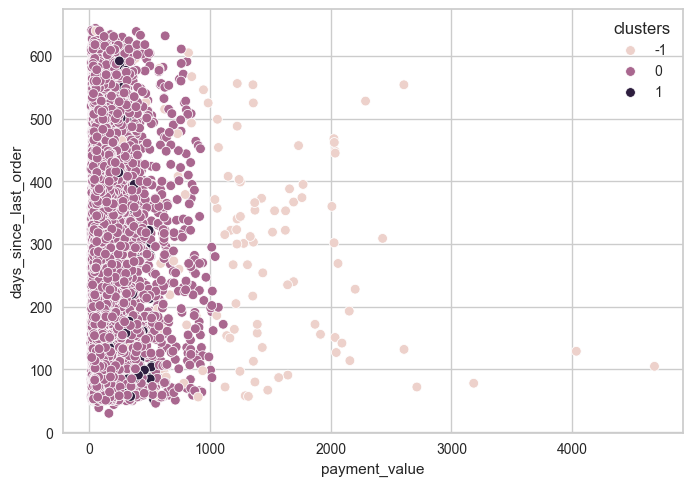

In [73]:
model = DBSCAN(eps=0.9, min_samples=50)

model.fit(X_scaled)

X['clusters'] = model.labels_

cols = ['payment_value', 'order_count', 'days_since_last_order']

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
display(results)

sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

,payment_value,order_count,days_since_last_order
clusters,,,
-1,651.179823,1.685841,269.922566
0,134.579139,1.000000,274.964740


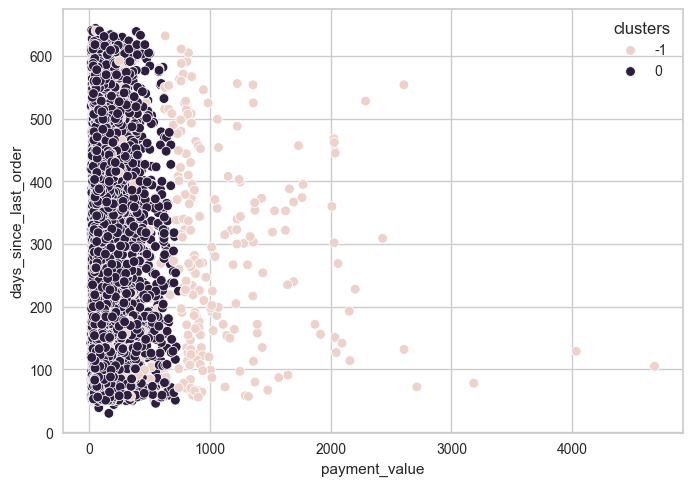

In [74]:
model = DBSCAN(eps=0.9, min_samples=150)

model.fit(X_scaled)

X['clusters'] = model.labels_

cols = ['payment_value', 'order_count', 'days_since_last_order']

results = X.groupby('clusters')[cols].mean().reset_index()
results.set_index('clusters', inplace=True)
display(results)

sns.scatterplot(data=X, x='payment_value', y='days_since_last_order', hue='clusters');

Les clusters sont moins bien définis malgré le silhouette score plus élevé. Le DBSCAN ne semble par exemple pas être en mesure de créer de clusters temporels à cause de la continuité des commandes. Il s'agit pourtant d'un critère important pour Olist.

Nous allons rester le KMeans pour faire notre segmentation

Par ailleurs, le modèle le plus simple est celui qui donne les meilleurs résultats.

<h2>3.4 Segmentation avec clustering agglomeratif</h2><a class="anchor" id="34"></a>

In [75]:
def agglomerative_scorer(data, clusters):
    
    score_df = pd.DataFrame(columns=['n_clusters',
                                     'silhouette', 'calinski-harabasz',
                                     'time'])
    
    from sklearn.cluster import AgglomerativeClustering
    
    for c in clusters:
        
        print(f'Fitting Agglomerative Clustering for {c} clusters')
        
        start_time = perf_counter()
        
        model = AgglomerativeClustering(n_clusters=c)
        
        model.fit(X_scaled)
        
        end_time = perf_counter()
        
        elapsed = round(end_time - start_time, 3)
        
        clusters = model.labels_
        
        silhouette = round(silhouette_score(X_scaled, clusters), 2)
        
        calinski = round(calinski_harabasz_score(X_scaled, clusters))
        
        n_clusters = len(set(clusters))
        
        row = {
            'n_clusters': n_clusters,
            'silhouette': silhouette,
            'calinski-harabasz': calinski,
            'time': elapsed
            
        }
        
        l = len(score_df)
        
        score_df.loc[l] = row
        
    
    return score_df

clusters = [3, 4, 5, 6, 7]

score_ac = agglomerative_scorer(sample, clusters)
score_ac

Fitting Agglomerative Clustering for 3 clusters
Fitting Agglomerative Clustering for 4 clusters
Fitting Agglomerative Clustering for 5 clusters
Fitting Agglomerative Clustering for 6 clusters
Fitting Agglomerative Clustering for 7 clusters


,n_clusters,silhouette,calinski-harabasz,time
0,3,0.44,3462,2.206
1,4,0.47,4580,2.053
2,5,0.47,5639,2.166
3,6,0.47,6088,2.244
4,7,0.38,6718,2.473


Avec l'algorithme de clustering agglomeratifs, nous obtenons le meilleur silhouette score entre 4 et 6 clusters. Le score calinski harabasz semble s'améliorer avec le nombre de clusters mais sont-il réelement plus parlant?

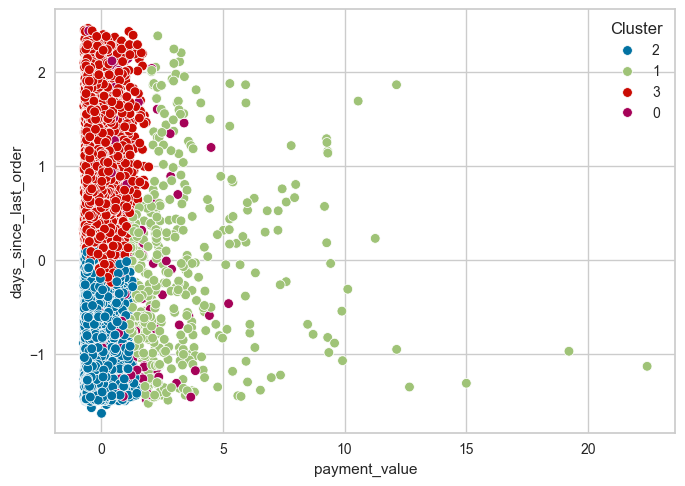

In [76]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=4)
model.fit(X_scaled)

results = X_scaled.copy()
results["Cluster"] = model.labels_
results["Cluster"] = results["Cluster"].astype(str)

sns.scatterplot(data=results, x='payment_value', y='days_since_last_order', hue='Cluster');

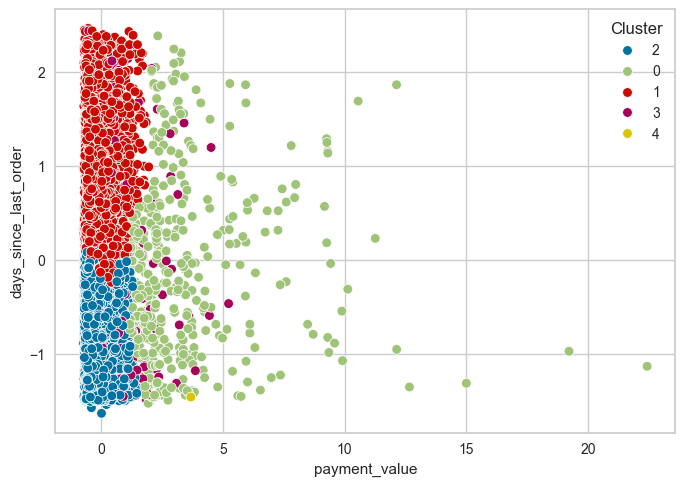

In [77]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=5)
model.fit(X_scaled)

results = X_scaled.copy()
results["Cluster"] = model.labels_
results["Cluster"] = results["Cluster"].astype(str)

sns.scatterplot(data=results, x='payment_value', y='days_since_last_order', hue='Cluster');

In [83]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(X_scaled)

results = X_scaled.copy()
results["Cluster"] = model.labels_
results["Cluster"] = results["Cluster"].astype(str)

In [79]:
model.children_

array([[   17,  7305],
       [ 3653,  4092],
       [   65,  5067],
       ...,
       [18822, 18823],
       [18820, 18824],
       [18821, 18825]], dtype=int64)

In [80]:
model.distances_

array([  0.        ,   0.        ,   0.        , ...,  97.89199815,
       108.3525245 , 110.45353309])

In [81]:
from scipy.cluster.hierarchy import dendrogram, linkage

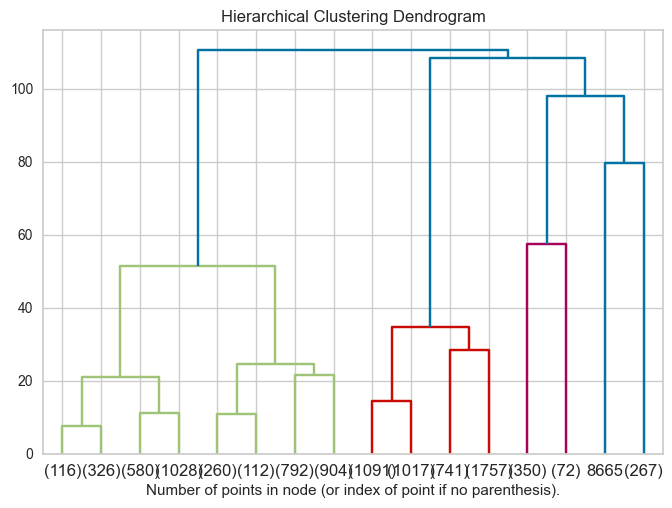

In [82]:
def plot_dendrogram(m, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(m.children_.shape[0])
    n_samples = len(m.labels_)
    for i, merge in enumerate(m.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [m.children_, m.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()